# New Section

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
test_dir = 'Dataset\Dataset\Test'
#train_dir = 'Data/train'

In [5]:
# Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):

    #checkpoint = torch.load(filepath,map_location='cpu') #unka
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model = models.resnet34(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [6]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(test_dir)
classes


['0% Rotten', '100% Rotten', '25% Rotten', '50% Rotten', '75% Rotten']

In [7]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(image)

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], 
                                                         [0.5, 0.5, 0.5])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [8]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [9]:
def plot_solution(image_path, model_path):
    #carname = cardir.split('/')[6]
    conf2, predicted1 = predict(image_path, model_path, topk=5)
    names = []
    for i in range(5):
        names += [classes[predicted1[i]]]
    image = Image.open(image_path)
    f, ax = plt.subplots(2,figsize = (6,10))

    ax[0].imshow(image)
    ax[0].set_title(imgdir)

    y_names = np.arange(len(names))
    ax[1].barh(y_names, conf2/conf2.sum(), color='red')
    ax[1].set_yticks(y_names)
    ax[1].set_yticklabels(names)
    ax[1].invert_yaxis() 

plt.show()

c:\Users\sai64\OneDrive\Desktop\Studies\mini\Detection-of-Rotten-Fruits-DRF-Using-Image-Processing-Python\work\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sai64\OneDrive\Desktop\Studies\mini\Detection-of-Rotten-Fruits-DRF-Using-Image-Processing-Python\work\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


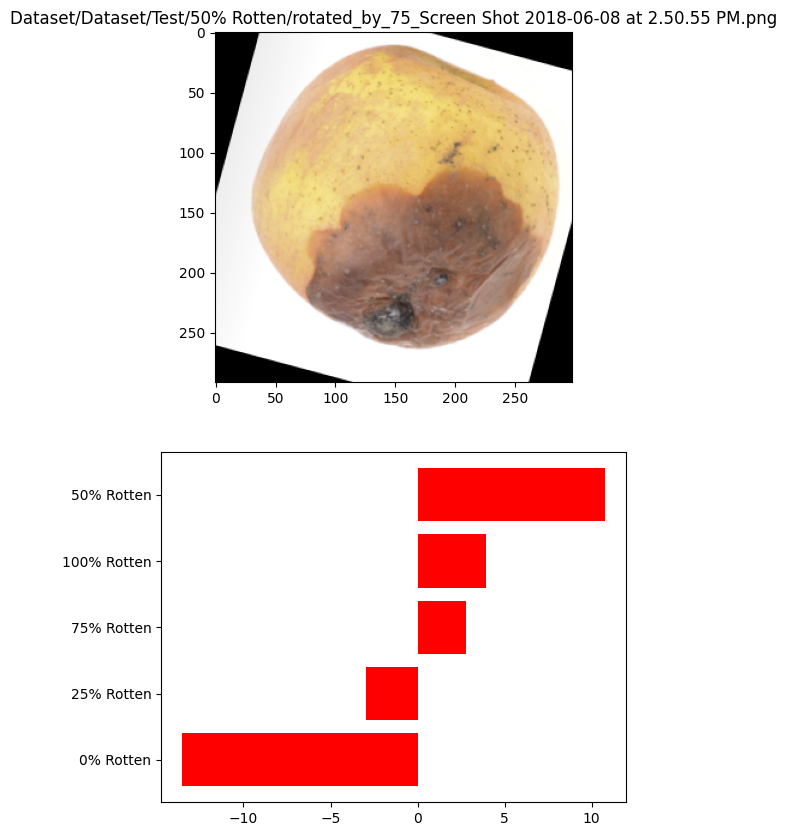

In [11]:
model_name = "modelFinal"
model_path = "Model/"+model_name+".pth"

imgdir='Dataset/Dataset/Test/50% Rotten/rotated_by_75_Screen Shot 2018-06-08 at 2.50.55 PM.png'
plot_solution(imgdir, model_path)
